# Análise de Retenção de Clientes com Regressão Logística

**Tarefa 5 da disciplina Análise Estatística de Dados e Informações, ministrada por João Gabriel de Moraes Souza**

**Aluno**: Adam Victor Nazareth Brandizzi

## Introdução

A retenção de clientes é um termo que refere-se tanto a uma métirca que avaialia quantos clientes permanecem ligados a uma instituição quanto procedimentos tomados para manter ou incrementar esta métrica. Isto ocorre porque o processo de aquisição de clientes é geralmente muito mais caro que a manutenção, e uma alta evasão (comumente chamada *churn*) pode indicar problemas fundamentais em uma empresa.

Neste trabalho, avaliaremos as estatísticas de clientes de uma instituição bancária, tentando identificar que fatores podem levar a uma evasão maior ou menor. Para isto, vamos utilizar a base [Predicting Churn for Bank Customers](https://www.kaggle.com/datasets/adammaus/predicting-churn-for-bank-customers?resource=download).

## Análise exploratória inicial

In [1]:
import pandas as pd
df = pd.read_csv('./Churn_Modelling.csv')
pd.DataFrame(dict(columns=df.columns))

,columns
0,RowNumber
1,CustomerId
2,Surname
3,CreditScore
4,Geography
5,Gender
6,Age
7,Tenure
8,Balance
9,NumOfProducts


As colunas `RowNumber`, `CustomerId` e `Surname` podem, razoavelmente, ser descartadas sem grande análise: não esperamos que o nome ou o identificador (arbitrário) do cliente acrescentaria muita informação. A coluna `Exited` contém a variável dependente que desejamos prever, e as demais, as variáveis independentes (i.e. fatores) que temos disponíveis.

In [2]:
X = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1).copy()
Y = df['Exited'].copy()

Note que, dos fatores restantes, dois são categóricos:  `Geography` e `Gender`. Vamos tomar nota, pois eventualmente teremos de codificá-los em valores numéricos.


In [3]:
categorical_factors = ['Geography', 'Gender']

Para avaliar como melhor utilizar essas variáveis, vamos executar dois procedimentos:

- verificar se a base está balanceada e, se não, balanceá-la; e
- verificar os pré-requisitos dos fatores para regressão logística.

### Balanceamento da base

Verifiquemos se a base está balanceada:

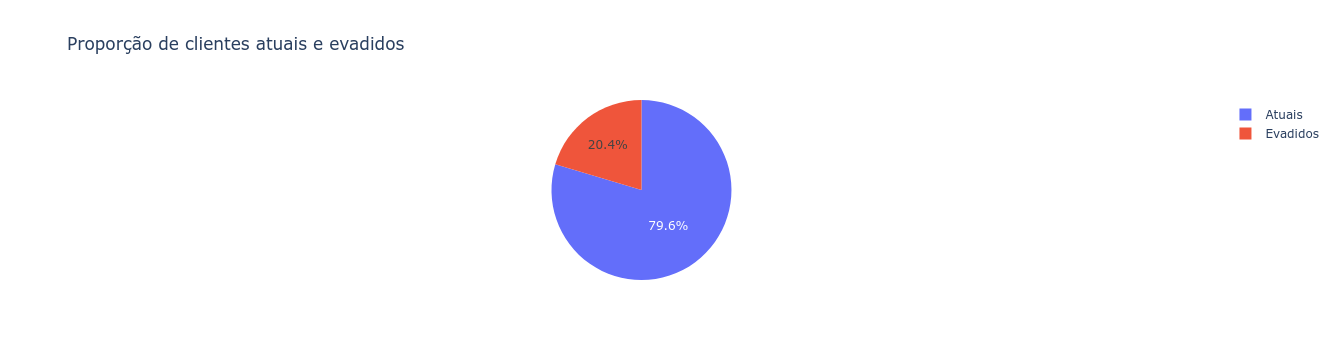

,counts
Exited,
0,7963
1,2037


In [4]:
import plotly.express as px

def show_dataset_balance(df):
    counts = df.value_counts()
    counts_df = pd.DataFrame(dict(counts=counts), index=counts.index)
    counts_graph = px.pie(
        title='Proporção de clientes atuais e evadidos',
        values=counts_df['counts'],
        names=['Atuais', 'Evadidos']
    )
    counts_graph.show()
    return counts_df

show_dataset_balance(Y)

Claramente, temos cinco clientes que não saíram para cada cliente que saiu. Isso é desbalanceado, então vamos balancear a base utilizndo [SMOTENC](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTENC.html).

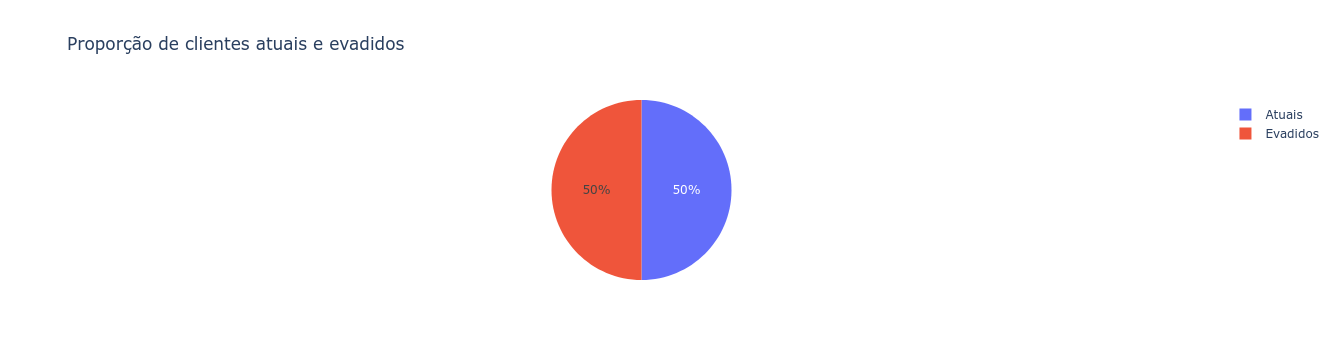

,counts
Exited,
1,7963
0,7963


In [5]:
from imblearn.over_sampling import SMOTENC

smotenc = SMOTENC(categorical_features=[X.columns.get_loc(f) for f in categorical_factors], random_state=42)
X, Y = smotenc.fit_resample(X, Y)

show_dataset_balance(Y)

Com a base balanceada, podemos prosseguir para analisar os pré-requisitos da regressão logística:
- ausência de colinearidade entre fatoreds;
- linearidade entre fatores e o logit das razões de chances.

### Colinearidade

A colinearidade pode ser verificada utilizando o [fator de inflação de variância](https://www.datacamp.com/pt/tutorial/variance-inflation-factor).

In [6]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Since VIF is calculated from R^2, we will need to do a regression
# and thus we need the constant column for the intercept.
X = sm.add_constant(X)
# Enconding categorical values
X = pd.get_dummies(X, columns=categorical_factors, drop_first=True, dtype=int)

In [7]:
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif[vif['feature'] != 'const']

,feature,VIF
1,CreditScore,1.002552
2,Age,1.159626
3,Tenure,1.008352
4,Balance,1.323502
5,NumOfProducts,1.105266
6,HasCrCard,1.031644
7,IsActiveMember,1.187087
8,EstimatedSalary,1.003837
9,Exited,1.532697
10,Geography_Germany,1.469346


Como todos os valores estão bem próximos de 1, é razoável assumir que nenhum campo tem alta colinearidade, então podemos escolher quaisquer uns deles.

## Linearidade com o logit da probabilidade

Outro pré-requisito para regressão logística é uma relação quase linear entre os fatores e o log da razão de chance (i.e. a logit da probabilidade):

$$
X_1, X_2, ..., X_n \sim_{linear} Y
$$

Para verificar isso, vamos utilizar o teste de Box-Tidwell

# Apêndice - Sandbox


In [8]:
categorical_factors

['Geography', 'Gender']